# Part 2: Handling the Cold Start Problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users and items with few interactions get excluded from the recommendation system. This is called the "cold start" problem. Content-based filtering handles this problem by generating recommendations based on user and item features.

## Step 1: Import the Dependencies

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Step 2: Load the Data

In this tutorial, we will be focusing on the `movies` dataset.


In [22]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

Let's take a peak at our `movies` dataframe.

In [23]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Step 3: Data Cleaning

The `movies` dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make our lives easier when it comes to analysis.
- `title` currently has `(year)` appended at the end. We will extract year from each title string and create a new column for it.

First, let's convert `genres` column from string to list.

In [24]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"


#### Cleaning up the `title` column

Our second data cleaning task is to clean up the title column by removing the year. Let's do this by first creating a function that can clean a single 'title' string, then apply it to the entire column using pandas' [apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) method.

In [25]:
title = movies['title'][0]

print(title)

def get_title(title):
    t = title.split(' ')
    t.pop()
    t = ' '.join(t)
    return t

get_title(title)

Toy Story (1995)


'Toy Story'

In [26]:
def get_year(title):
    t = title.split(' ')
    year = t.pop()
    year = year.strip('()')
    return year

get_year(title)

'1995'

We can use the `apply` method to apply our functions `get_title()` and `get_year()` to the `title` column of our dataframe.

In [27]:
movies['year'] = movies['title'].apply(get_year)
movies['title'] = movies['title'].apply(get_title)

We now have a nice, clean dataframe with proper title and year columns. Let's take a peak at the first few rows.

In [50]:
movies.head()

,movieId,title,genres,year,Drama,Thriller,Comedy,Western,IMAX,Sci-Fi,...,Mystery,Film-Noir,Fantasy,Adventure,War,(no genres listed),Musical,Romance,Documentary,Horror
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,Father of the Bride Part II,[Comedy],1995,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Step 4: Exploratory Data Analysis

Now that we have a clean dataframe, let's do some exploratory data analysis. 

### A Glimpse at Movie Genres

How many genres are there? What are the most common genres?

We can answer these questions using a helpful tool from `collections` called `Counter`. With `Counter`, you can count the overall frequency of each genre by iterating through each movie's list of genres. Genres are stored as dictionary keys and their counts are stored as values. The `collections` package comes pre-installed with Python so no need to `pip install`!

In [29]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [30]:
genre_frequency.most_common(5)

[('Drama', 4361),
 ('Comedy', 3756),
 ('Thriller', 1894),
 ('Action', 1828),
 ('Romance', 1596)]

There are 20 genres mentioned in our `movies` dataset. The 5 most common genres are: Drama, Comedy, Thriller, Action, and Romance.

Let's visualize these findings with a barplot. We first need to convert `genre_frequency` to a dataframe for the barplot to work.

In [31]:
genre_df = pd.DataFrame.from_dict(genre_frequency, orient='index').reset_index()
genre_df.columns = ['genre', 'count']

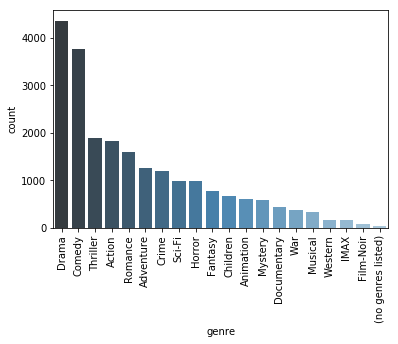

In [45]:
plt.figure(figsize=(6,4))
sns.barplot(x='genre', y='count', data=genre_df.sort_values(by='count', ascending=False), palette='Blues_d')
plt.xticks(rotation=90)
plt.show()

### Year of Release

In [33]:
years = map(str, np.arange(1980,2018))
year_frequencies = movies[movies['year'].isin(list(years))]['year'].value_counts().reset_index()
year_frequencies.columns = ['year_of_release', 'count']

The `year_of_release` column is currently in string format. We're going to have to convert this column's datatype to integer.

In [34]:
year_frequencies['year_of_release'] = year_frequencies['year_of_release'].astype(int)

Now let's visualize the years of release.

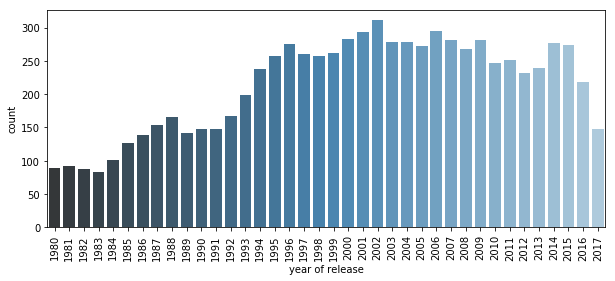

In [44]:
plt.figure(figsize=(10,4))
sns.barplot(x='year_of_release', y='count', data=year_frequencies.sort_values(by='year_of_release'), palette='Blues_d')
plt.xticks(rotation=90)
plt.xlabel('year of release')
plt.show()

## Step 5: Data Pre-processing

We're almost ready to build our content-based recommender system! We just need to wrangle our `movies` dataframe into the appropriate format. In Part 1, we formatted our data as a user $\times$ item matrix. Here, we are going to represent our data as a movie $\times$ movie feature (i.e., genre) matrix. Each row will represent a movie, while each column will represent a movie genre. The cells in this matrix will be populated with 0's and 1's.

<img src="images/movie-features-matrix.png" width=40%/>

In [36]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [47]:
genres = set(g for G in movies['genres'] for g in G)

movie_genres_matrix = movies

for g in genres:
    movie_genres_matrix[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres_matrix = movies.drop(columns=['movieId', 'year', 'title','genres'])

In [51]:
print(f"Dimensions of movie-genres matrix: {movie_genres_matrix.shape}")
movie_genres_matrix.head()


Dimensions of movie-genres matrix: (9742, 20)


,Drama,Thriller,Comedy,Western,IMAX,Sci-Fi,Animation,Children,Action,Crime,Mystery,Film-Noir,Fantasy,Adventure,War,(no genres listed),Musical,Romance,Documentary,Horror
0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Step 6: Finding Similar Movies using Cosine Similarity

We are going to use `scikit-learn`'s cosine similarity to generate item-item recommendations.

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

# create mapper that maps index to title and vice versa
movie_indices = dict(zip(movies['title'], list(movies.index)))
cosine_sim = cosine_similarity(movie_genres_matrix, movie_genres_matrix)

print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


The dimensions of our cosine similarity matrix are $M \times M$ where $M$ represents the total number of movies.

In [40]:
title = movies['title'][0]
n_recommendations = 10

idx = movie_indices[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

print(f"Recommendations for {title}:")
movies['title'].iloc[similar_movies]

Recommendations for Toy Story:


1706                                                Antz
2355                                         Toy Story 2
2809             Adventures of Rocky and Bullwinkle, The
3000                           Emperor's New Groove, The
3568                                      Monsters, Inc.
6194                                           Wild, The
6486                                     Shrek the Third
6948                             Tale of Despereaux, The
7760    Asterix and the Vikings (Astérix et les Vikings)
8219                                               Turbo
Name: title, dtype: object

With this approach, we are assuming that two movies are "similar" if they have similar genres. These "similar movie" recommendations are based solely on the metadata from our movies dataset. Feel free to test out different movies.